# Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import time
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [2]:
df = pd.read_csv(r'data/winequalityN - winequalityN.csv')

In [3]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
df.shape

(6497, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [6]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [7]:
df.isnull().mean() * 100

type                    0.000000
fixed acidity           0.153917
volatile acidity        0.123134
citric acid             0.046175
residual sugar          0.030783
chlorides               0.030783
free sulfur dioxide     0.000000
total sulfur dioxide    0.000000
density                 0.000000
pH                      0.138525
sulphates               0.061567
alcohol                 0.000000
quality                 0.000000
dtype: float64

In [8]:
df.duplicated().sum()

1168

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(5329, 13)

# Train Test Split

In [11]:
X = df.drop('type', axis=1)
y = df['type']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4263, 12), (1066, 12), (4263,), (1066,))

# Distribution of data

## Numeric Columns - Histogram and Box Plot

In [14]:
def visualize_distribution(df):
    numeric_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'quality']
    palette = sns.color_palette("Set2", n_colors=len(numeric_cols))

    for i, col in enumerate(numeric_cols):
        print(f'Skewness of {col}: {df[col].skew():.2f}')
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        # Histogram
        sns.histplot(data=df, x=col, stat='density', kde=True, color=palette[i], ax=ax[0])
        ax[0].set_title(f'Histogram of {col}', fontsize=12)
        ax[0].set_xlabel(col)
        ax[0].set_ylabel('Density')

        # Box Plot
        sns.boxplot(data=df, x=col, color=palette[i], ax=ax[1])
        ax[1].set_title(f'Box Plot of {col}', fontsize=12)
        ax[1].set_xlabel(col)

        plt.tight_layout()
        plt.show()

Skewness of fixed acidity: 1.65


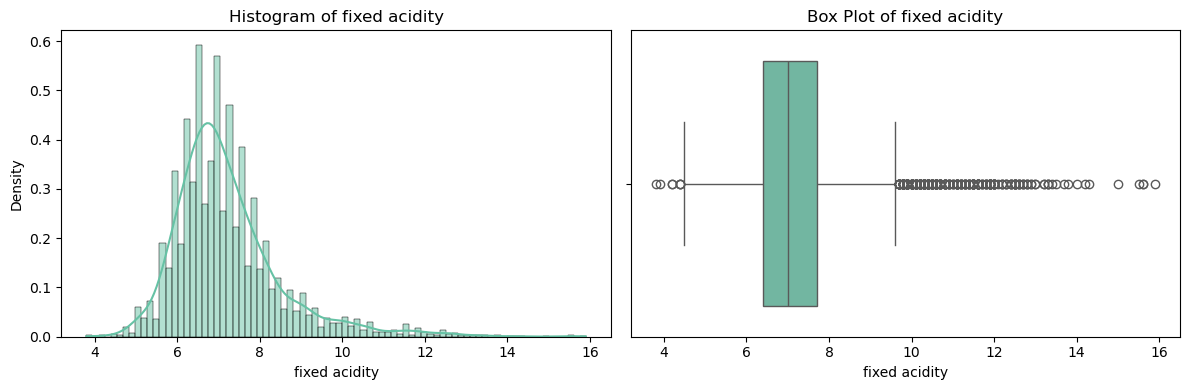

Skewness of volatile acidity: 1.51


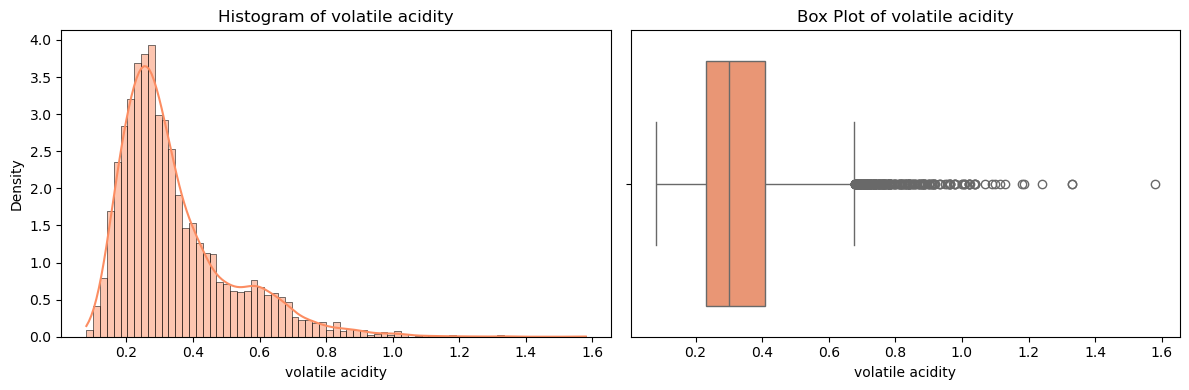

Skewness of citric acid: 0.48


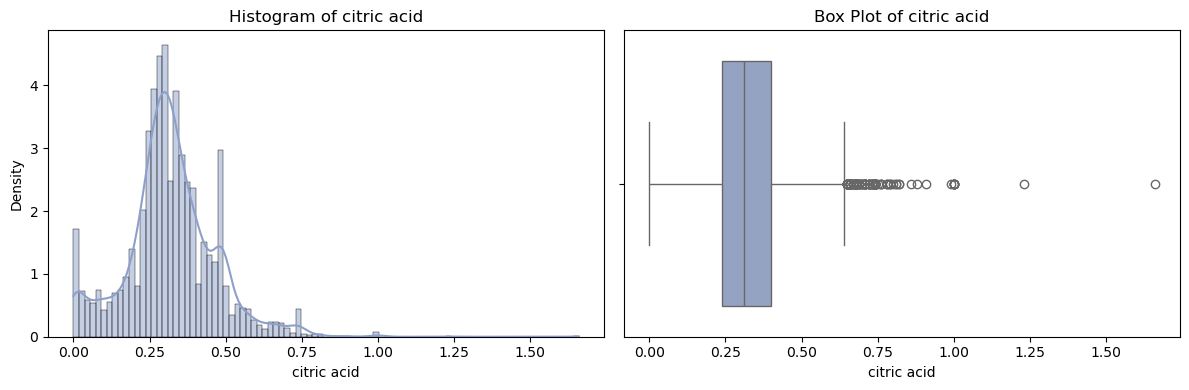

Skewness of residual sugar: 1.70


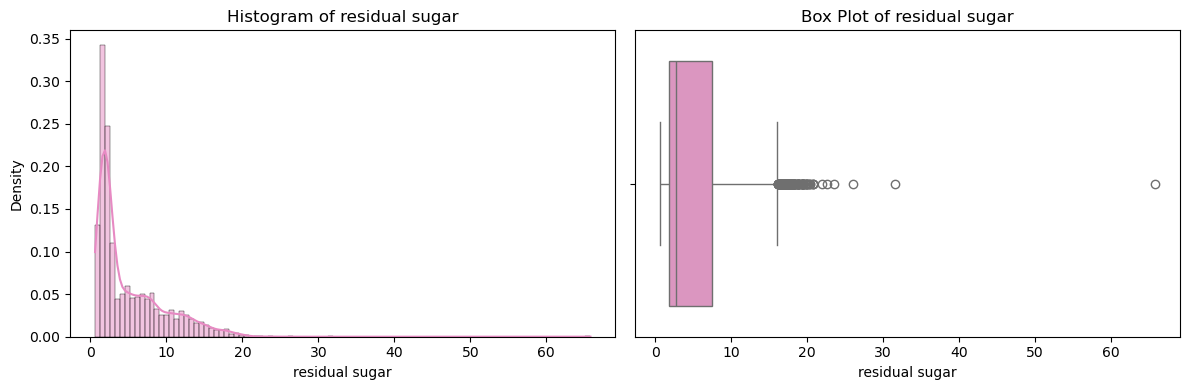

Skewness of chlorides: 5.34


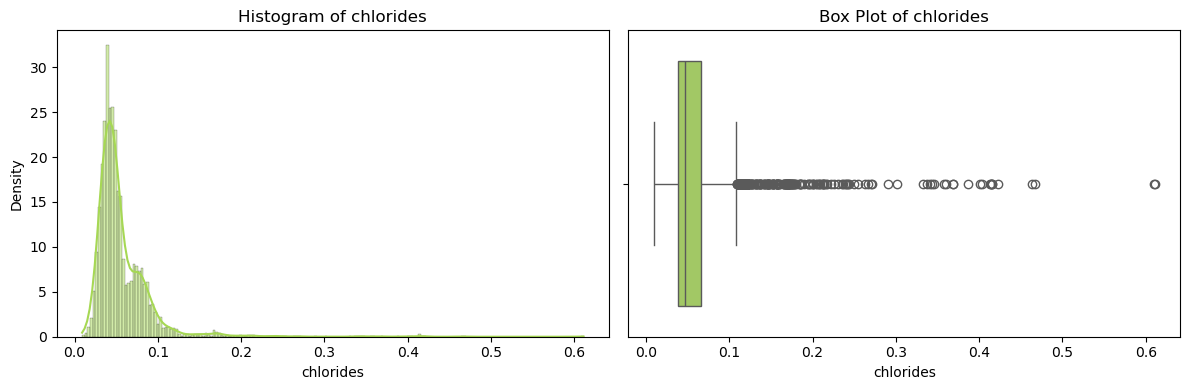

Skewness of free sulfur dioxide: 1.36


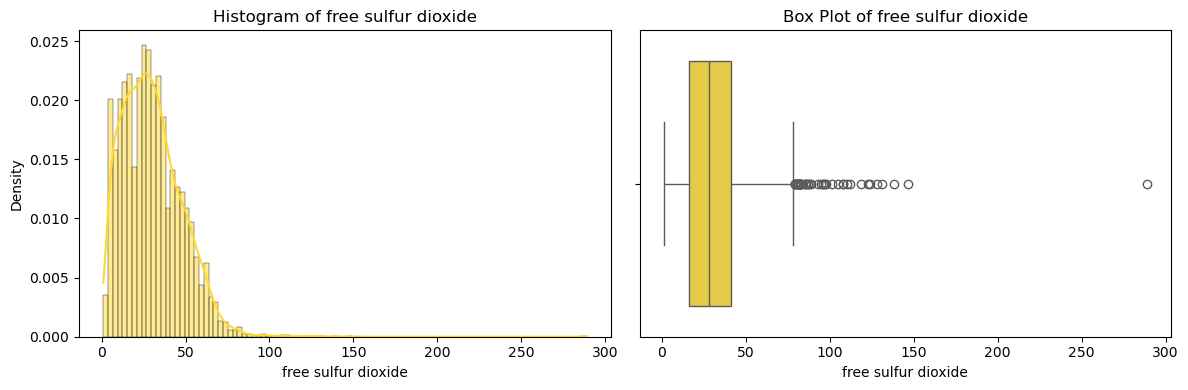

Skewness of total sulfur dioxide: 0.06


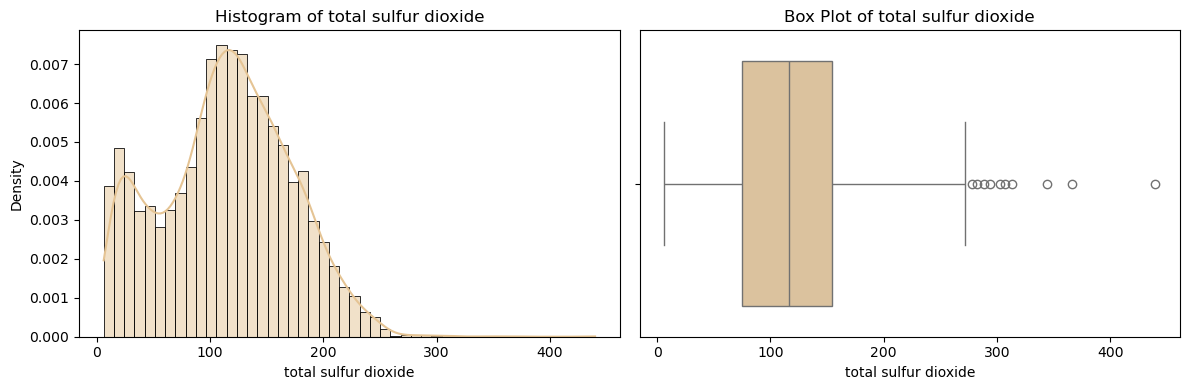

Skewness of density: 0.66


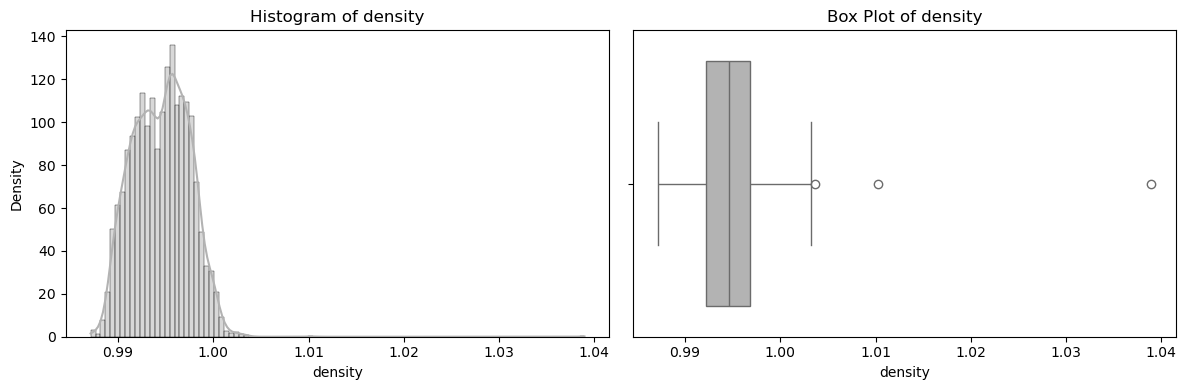

Skewness of pH: 0.39


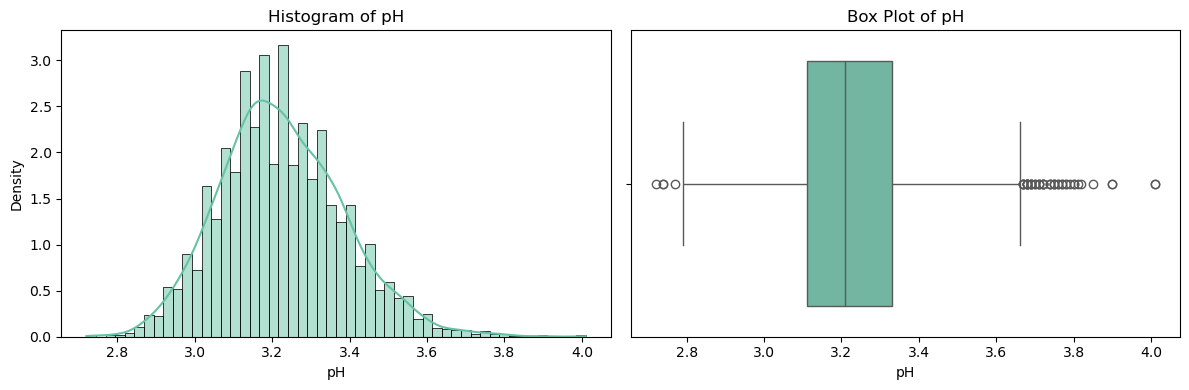

Skewness of sulphates: 1.81


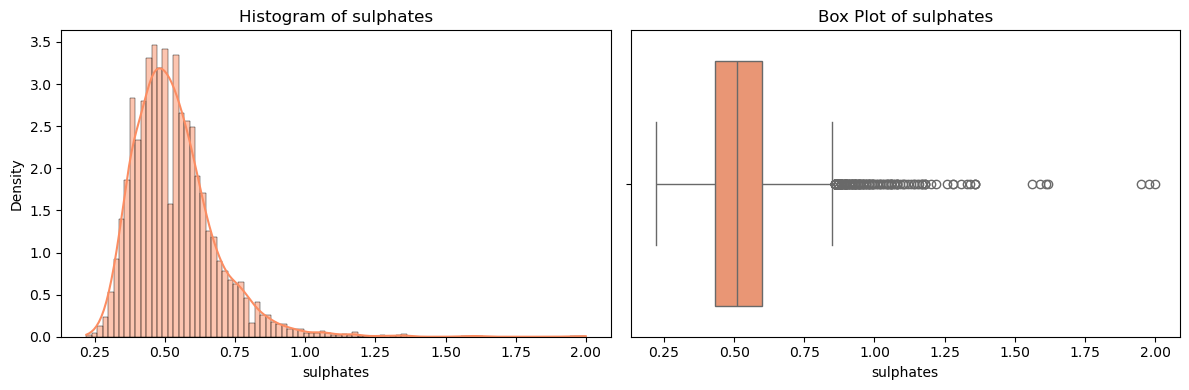

Skewness of alcohol: 0.55


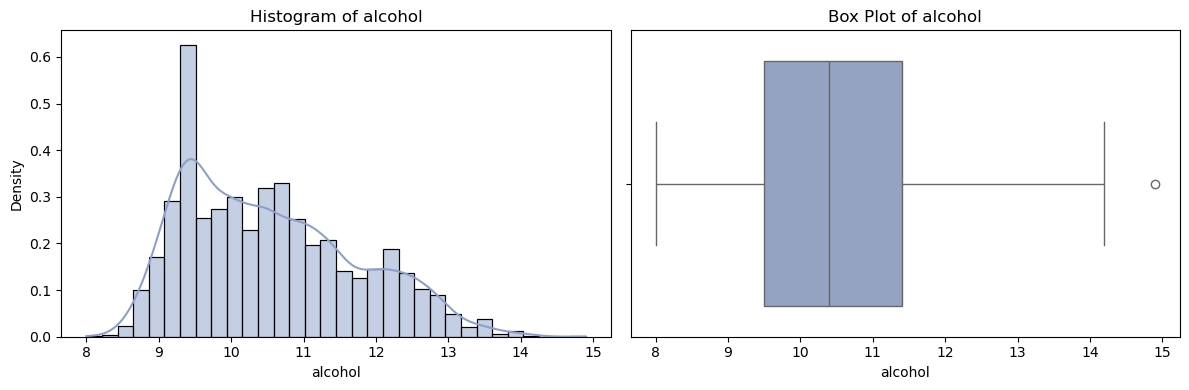

In [15]:
visualize_distribution(df)

## Strategy for Imputing Missing values and Outlier Removal

In [16]:
numeric_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'quality']
numeric_cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [17]:
skewness = df[numeric_cols].skew()
skewness

fixed acidity           1.650439
volatile acidity        1.505053
citric acid             0.484386
residual sugar          1.702734
chlorides               5.340966
free sulfur dioxide     1.358640
total sulfur dioxide    0.061697
density                 0.664751
pH                      0.391215
sulphates               1.809208
alcohol                 0.546145
dtype: float64

In [18]:
imputation_strategy_df = pd.DataFrame({'Column': skewness.index, 'Skewness': skewness.values})
imputation_strategy_df

,Column,Skewness
0,fixed acidity,1.650439
1,volatile acidity,1.505053
2,citric acid,0.484386
3,residual sugar,1.702734
4,chlorides,5.340966
5,free sulfur dioxide,1.358640
6,total sulfur dioxide,0.061697
7,density,0.664751
8,pH,0.391215
9,sulphates,1.809208


In [19]:
def classify_features(skew):
    if -0.5 <= skew <= 0.5:
        return pd.Series(['Symmetric', 'Mean', 'Z-Score'])
    else:
        return pd.Series(['Skewed', 'Median', 'IQR'])

In [20]:
imputation_strategy_df[['Distribution Type', 'Imputation Strategy', 'Outlier Removal Method']] = imputation_strategy_df['Skewness'].apply(classify_features)
imputation_strategy_df.reset_index(drop=True, inplace=True)
imputation_strategy_df

,Column,Skewness,Distribution Type,Imputation Strategy,Outlier Removal Method
0,fixed acidity,1.650439,Skewed,Median,IQR
1,volatile acidity,1.505053,Skewed,Median,IQR
2,citric acid,0.484386,Symmetric,Mean,Z-Score
3,residual sugar,1.702734,Skewed,Median,IQR
4,chlorides,5.340966,Skewed,Median,IQR
5,free sulfur dioxide,1.358640,Skewed,Median,IQR
6,total sulfur dioxide,0.061697,Symmetric,Mean,Z-Score
7,density,0.664751,Skewed,Median,IQR
8,pH,0.391215,Symmetric,Mean,Z-Score
9,sulphates,1.809208,Skewed,Median,IQR


# Pipelines

## Numeric Pipeline

In [21]:
num_cols_mean = [row['Column'] for _, row in imputation_strategy_df.iterrows() if row['Imputation Strategy'] == 'Mean']
num_cols_mean

['citric acid', 'total sulfur dioxide', 'pH']

In [22]:
num_cols_median = [row['Column'] for _, row in imputation_strategy_df.iterrows() if row['Imputation Strategy'] == 'Median']
num_cols_median

['fixed acidity',
 'volatile acidity',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'density',
 'sulphates',
 'alcohol']

In [23]:
# Mean Imputation + Z-Score
num_mean_zscore_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

# Median Imputation + IQR
num_median_iqr_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

## Preprocessor

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_zscore', num_mean_zscore_pipeline, num_cols_mean),
        ('num_iqr', num_median_iqr_pipeline, num_cols_median),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True,
    verbose=True
)

## Complete Pipeline

In [25]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=None)),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]
)

## Fit the model

In [26]:
pipe.fit(X_train, y_train)

[ColumnTransformer] .... (1 of 3) Processing num_zscore, total=   0.0s
[ColumnTransformer] ....... (2 of 3) Processing num_iqr, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_zscore',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['citric acid',
                                                   'total sulfur dioxide',
                                                   'pH']),
                                                 ('num_iqr',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'density', 'sulphates',
                                                   'alcohol'])],
                                   verbose=True)),
                ('pca', PCA()), ('classifier', KNeighborsClassifier())])

## Prediction on test data

In [27]:
y_pred = pipe.predict(X_test)

## Accuracy Score

In [28]:
print('Accuracy Score is: ', accuracy_score(y_test, y_pred))

Accuracy Score is:  0.9906191369606003


## Eigen Values

In [29]:
pipe.named_steps['pca'].explained_variance_

array([3.02693501, 2.58861177, 1.64520768, 1.02314789, 0.80899833,
       0.65852368, 0.52821026, 0.49787552, 0.44767284, 0.29186062,
       0.22347903, 0.03523288])

## Eigen Vectors

In [30]:
pipe.named_steps['pca'].components_

array([[ 0.12315148,  0.45977422, -0.16979257, -0.28839989, -0.39817955,
         0.27158405, -0.33660671,  0.42187135, -0.16774671, -0.31753834,
         0.00660428,  0.09402038],
       [ 0.18365923,  0.20326062, -0.17705676,  0.24523238,  0.05541494,
         0.38321545,  0.23760994,  0.17093512,  0.54191967,  0.10416243,
        -0.48661516, -0.237788  ],
       [ 0.58962207, -0.09497801, -0.43736981,  0.44319566, -0.29622761,
        -0.11800901,  0.05478934, -0.08637582, -0.10613049,  0.15018599,
         0.23510284,  0.23319051],
       [ 0.13796191,  0.13960027,  0.47952305, -0.17253581, -0.12293383,
         0.06792959,  0.20936774,  0.29910904,  0.08479388,  0.61459614,
         0.13534278,  0.38144857],
       [-0.07617678, -0.19076859,  0.14571788,  0.23914596,  0.12904938,
         0.51686222, -0.48784417, -0.17047566,  0.34250348, -0.098429  ,
         0.26654786,  0.36122168],
       [ 0.36133473, -0.11666884,  0.53316169, -0.00917785, -0.46376358,
        -0.16118018, -

In [31]:
pipe.named_steps['pca'].components_.shape

(12, 12)

## Explained Variance Ratio

In [32]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.25704805, 0.21982554, 0.13971143, 0.08688597, 0.06870033,
       0.05592199, 0.04485574, 0.04227971, 0.03801649, 0.02478487,
       0.01897789, 0.00299198])

## Test the model on unseen data

In [33]:
new_data = pd.DataFrame([{
    'fixed acidity': 7.4,
    'volatile acidity': 0.70,
    'citric acid': 0.00,
    'residual sugar': 1.9,
    'chlorides': 0.076,
    'free sulfur dioxide': 11.0,
    'total sulfur dioxide': 34.0,
    'density': 0.9978,
    'pH': 3.51,
    'sulphates': 0.56,
    'alcohol': 9.4,
    'quality': 5
}])

# Predict
predicted_type = pipe.predict(new_data)
print("Predicted type:", predicted_type[0])

Predicted type: red


# Optimum Principal Components

In [34]:
pca = PCA(n_components=None)

In [35]:
X_train_ = X_train.dropna()
X_test_ = X_test.dropna()

In [36]:
X_train_trf = pca.fit_transform(X_train_)
X_test_trf = pca.transform(X_test_)

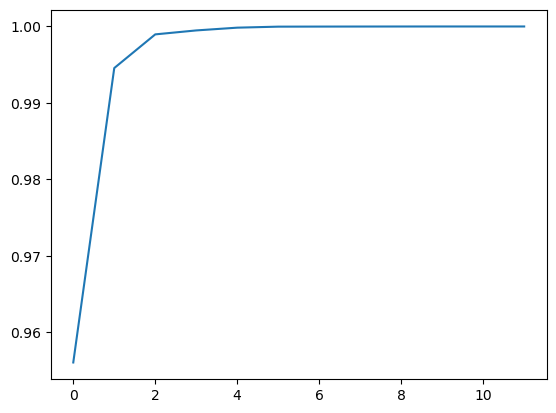

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# Conclusion

The optimum number of principal components to be selected are atleast 3